In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!pip install

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

Data Processing

In [ ]:
# Load "train" data in pd df

df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/24S_ICS435_FPROJECT/data/AIDS_Classification.csv')

#One Hot Encode the categorical variables
#df_encoded = pd.get_dummies(df, columns=['trt', 'hemo', 'homo', 'drugs', 'oprior', 'z30', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt'])

#Setting aside 10% of the data
test_df = df.sample(frac=0.1, random_state=435)
train_val_df = df.drop(test_df.index)

#Remaining data: training and validation sets
X_train_val = train_val_df.drop('infected', axis=1)
y_train_val = train_val_df['infected']

#
X_test = test_df.drop('infected', axis=1)
y_test = test_df['infected']

Defining the model, parameter grid and search space for RF.

In [ ]:
rfmodel = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rfmodel,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           verbose=3)

In [ ]:
grid_search.fit(X_train_val,y_train_val) #train models

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.930 total time=   0.3s
[CV 2/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.914 total time=   0.2s
[CV 3/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.943 total time=   0.2s
[CV 4/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.935 total time=   0.3s
[CV 5/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.887 total time=   0.3s
[CV 1/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.927 total time=   0.4s
[CV 2/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.912 total time=   0.4s
[CV 3/5] END max_depth=6, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.940 total time=   0.4s
[C

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='roc_auc', verbose=3)

In [ ]:
best_model = grid_search.best_estimator_ #define best model
print("Best hyperparameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)
results = pd.DataFrame(grid_search.cv_results_)
print(results[['param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score']])

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best ROC AUC Score: 0.9293555184980097
   param_n_estimators param_max_depth  mean_test_score  std_test_score
0                 100               6         0.921679        0.019932
1                 150               6         0.921152        0.017030
2                 200               6         0.920207        0.018189
3                 250               6         0.922199        0.018155
4                 300               6         0.921585        0.017813
..                ...             ...              ...             ...
85                100              10         0.925952        0.016616
86                150              10         0.927019        0.017346
87                200              10         0.927104        0.016390
88                250              10         0.926293        0.018235
89                300              10         0.927724        0.017174



In [ ]:
# proababilities for the positive class
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

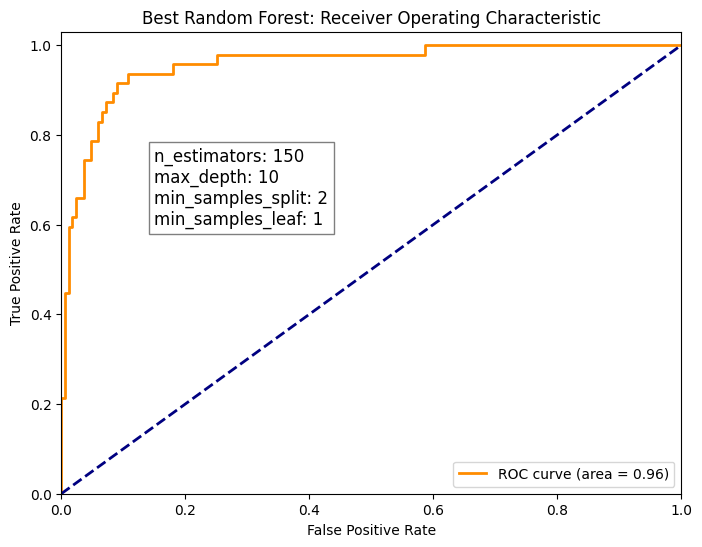

In [ ]:
#plot roc curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Random Forest: Receiver Operating Characteristic')
params_text = "n_estimators: 150\nmax_depth: 10\nmin_samples_split: 2\nmin_samples_leaf: 1"
plt.text(0.15, 0.6, params_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.legend(loc="lower right")
plt.show()

Save model

In [ ]:
import os

model_directory = './models'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

from joblib import dump
# path for model
model_path = os.path.join(model_directory, 'RF_model.joblib')

# Save model
dump(grid_search.best_estimator_, model_path)

['./models/RF_model.joblib']